<a name="0"></a> 

# Anomaly Detection 

The data consists of a one-dimensional temperature sensory signal for an internal component of a large industrial machine. The first anomaly is a planned shut down and takes place early in the signal in December. The second anomaly happens later in the signal in early February and is subtle in comparison but leads into a third anomaly which is considered a catastrophic failure. 

* [Link to Data](https://github.com/numenta/NAB/blob/master/data/realKnownCause/machine_temperature_system_failure.csv) 

---

## Models 

* **Hidden Markov Model with Normal Emission Probabilities** 
* **MADE: Masked Autoencoder for Density Estimation** 

---

## Notebook Outline 

* [1. Load and Plot Signal](#1) 
* [2. Hidden Markov Model with Normal Emissions](#2) 
* [3. Masked Autoencoder for Density Estimation ](#3) 
* [4. Summary and Conclusion](#4) 

---



In [1]:
import os 
os.chdir('../') 

import numpy as np 
from dspML import data, plot 
from dspML.preprocessing import sequence 
from dspML.models.sequence import NormalHMM as HMM 
from dspML.models.sequence import made 

<a name="1"></a> 

# 1. Load and Plot Signal 

* [Outline](#0) 


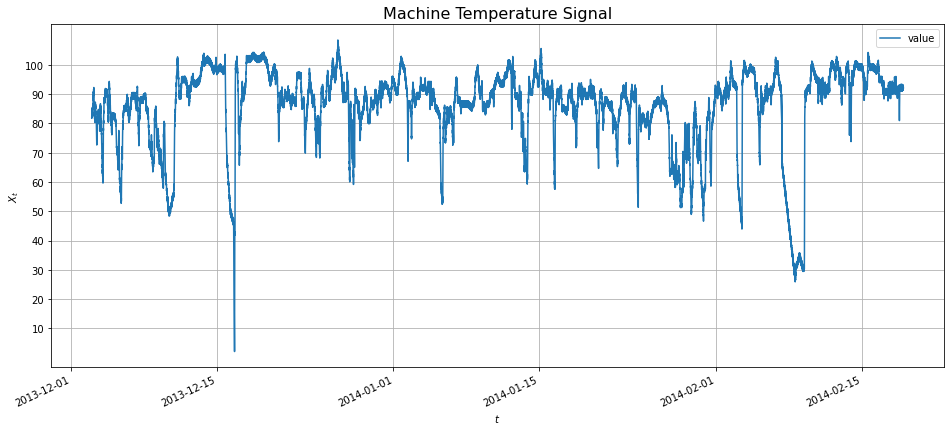

In [2]:
# load signal 
signal = data.machine_temperature() 

# plot full signal 
plot.signal_pd(signal, title='Machine Temperature Signal', figsize=(16, 7), 
               rotation=25, yticks=np.arange(10, 110, 10)) 

## Split Signal and Plot 

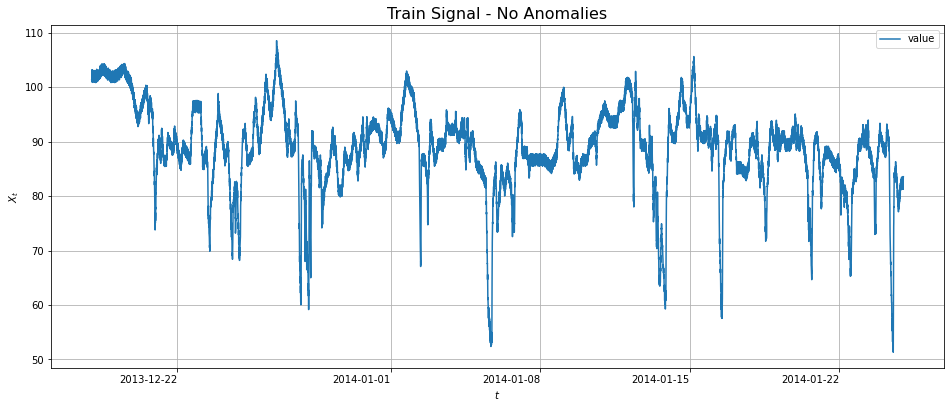

In [3]:
# train signal 
signal_train = signal.loc['2013-12-18 00:00:00':'2014-01-24 23:55:00'] 

# plot train signal 
plot.signal_pd(signal_train, title='Train Signal - No Anomalies', figsize=(16, 7)) 

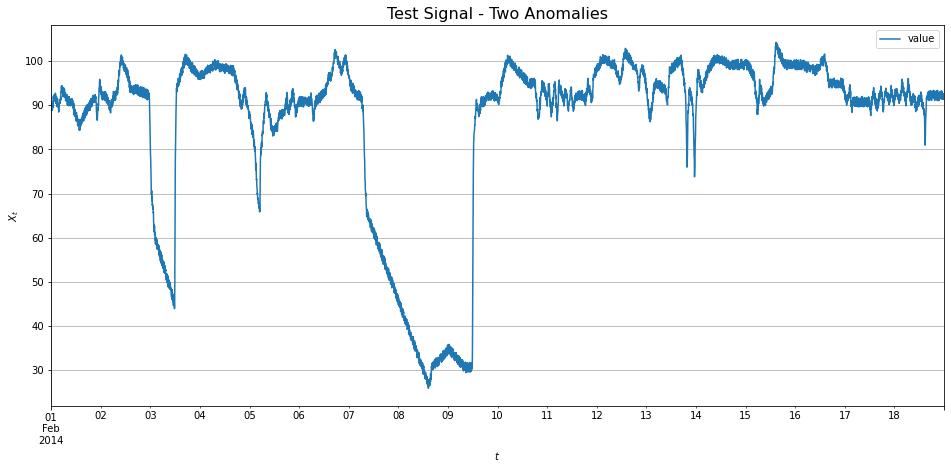

In [4]:
# test signal 
signal_test = signal.loc['2014-02-01 00:00:00':] 

# plot test signal 
plot.signal_pd(signal_test, title='Test Signal - Two Anomalies', figsize=(16, 7)) 

<a name="2"></a> 

# 2. Hidden Markov Model with Normal Emissions

* [Outline](#0) 
* [Section 3 Outline](#3) 
* [Summary and Conclusion](#4) 

---

## Section Outline 

* [Fit Model](#2-1) 
* [Posterior Inference](#2-2) 
* [Detect Anomalies](#2-3)

---

## Define Model 

The Hidden Markov model will be defined to have 3 hidden states following a uniform distribution and the transition probability matrix is defined to have a 0.001 probability of changing states. The observation distribution is normal where the mean is a trainable variable and a standard deviation of 5. The prior distribution is a normal distribution where the mean is the overall mean of the February portion of the signal and standard deviation equal to 10. 

In [5]:
# convert to numpy and reduce dimension 
x = sequence.reduce_dims(sequence.to_numpy(signal_test)) 

# define Hidden Markov Model and prior 
n_states = 3 
p_change = 0.001 
hmm, prior = HMM.NormalHMM(x, n_states, p_change) 

<a name="2-1"></a> 

## Fit Model 

[Section Outline](#2) 

The model is fit with gradient descent using the Adam optimizer to compute the maximum a posteriori. The loss function implemented is negative log probability loss and the fitting process runs for 501 epochs. 

In [6]:
# fit trainable mean parameter 
means = HMM.fit(hmm, prior, x) 

Epoch 0: log prob = -48970.5859375 | means = [87.201 87.219 85.559]
Epoch 20: log prob = -44258.2578125 | means = [89.235 88.885 83.566]
Epoch 40: log prob = -40269.02734375 | means = [91.418 89.257 81.608]
Epoch 60: log prob = -37300.0859375 | means = [93.11  89.292 79.698]
Epoch 80: log prob = -34922.17578125 | means = [94.322 89.368 77.842]
Epoch 100: log prob = -32836.25390625 | means = [95.269 89.651 76.041]
Epoch 120: log prob = -30959.376953125 | means = [96.083 90.107 74.294]
Epoch 140: log prob = -29305.009765625 | means = [96.728 90.497 72.603]
Epoch 160: log prob = -27836.2109375 | means = [97.224 90.758 70.967]
Epoch 180: log prob = -26519.017578125 | means = [97.608 90.921 69.386]
Epoch 200: log prob = -25336.462890625 | means = [97.881 90.99  67.86 ]
Epoch 220: log prob = -24269.9140625 | means = [98.059 90.996 66.387]
Epoch 240: log prob = -23306.765625 | means = [98.17  90.972 64.968]
Epoch 260: log prob = -22440.79296875 | means = [98.235 90.95  63.603]
Epoch 280: log 

<a name="2-2"></a> 

## Posterior Inference 

[Section Outline](#2) 

We can extract the posterior marginal distribution from the HMM and use it to find the posterior probabilities along with the most likely mean parameters and states of the system. We will use the marginal posterior distributions to obtain the most likely means and states of the system and visualize it to determine which state and mean is likely to be the anomolous indices of the signal. 

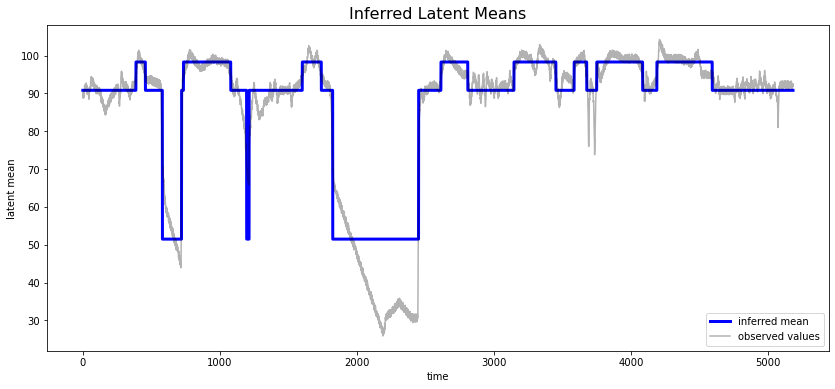

In [7]:
# posterior distribution and most likely states and means 
posterior_dists, ml_means, ml_states = HMM.posterior_inference(hmm, x) 

# plot inferred latent means 
HMM.plot_inferred_means(x, means, ml_means, ml_states) 

<a name="2-3"></a> 

## Detect Anomalies 

[Section Outline](#2) 

Since the latent state with the smallest inferred mean is very far from the rest of the signal we will let the observations in this state be anomalies. 

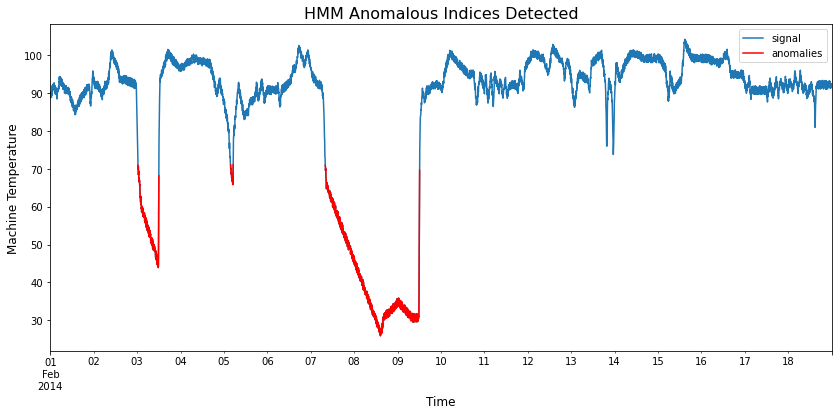

In [8]:
# detect anomalies 
anoms = HMM.anomalous_state(ml_states, state=2) 

# plot signal with anomalies flagged 
plot.anomalies(signal_test, anoms, title='HMM Anomalous Indices Detected') 

The model successfully captured both anomalies present in the system, but also flagged a neighborhood of observations that are not anomalous. Overall, it would be more beneficial to have a false warning and stop the system then to miss a potential anomaly and have the system completely fail. 

---

<a name="3"></a> 

# 3. Masked Autoencoder for Density Estimation 

* [Outline](#0) 
* [Section 2 Outline](#2) 
* [Summary and Conclusion](#4) 

---

## Section Outline 

* [Define Model](#3-1)
* [Fit Model](#3-2) 
* [Sample from the Transformed Distribution and Plot](#3-3) 
* [Test Signal Probabilities](#3-4) 
* [Detect Anomalies](#3-5) 

---

## Preprocess Train and Test Signals 

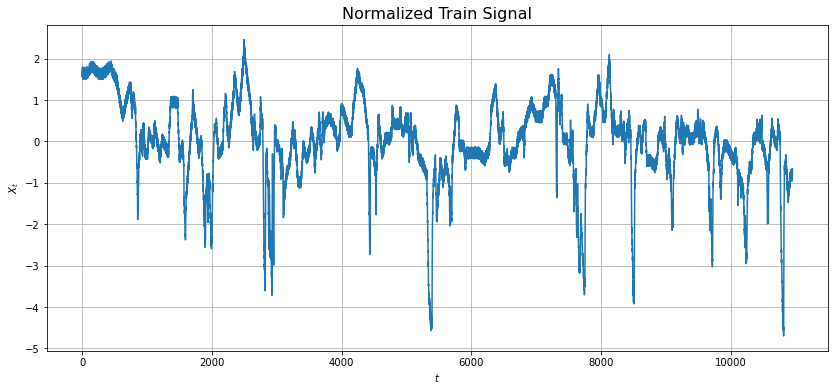

In [9]:
# convert to numpy array 
x_train = sequence.to_numpy(signal_train) 

# normalize signal 
x_train, norm = sequence.normalize_train(x_train) 

# plot signal 
plot.signal_np(x_train, title='Normalized Train Signal') 

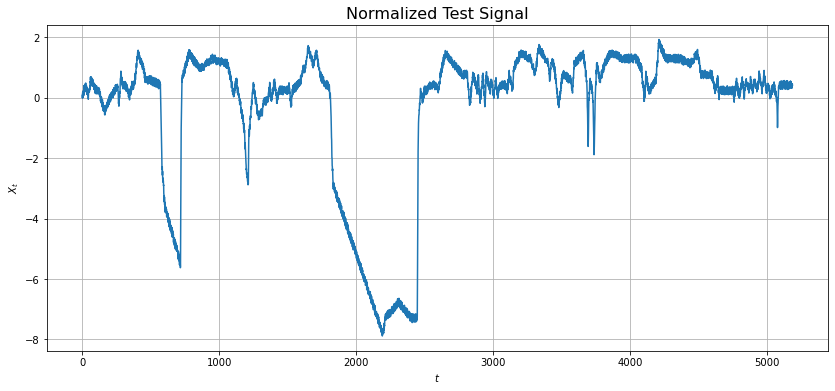

In [10]:
# convert to numpy array 
x_test = sequence.to_numpy(signal_test) 

# normalize signal 
x_test = sequence.normalize_test(x_test, norm) 

# plot signal 
plot.signal_np(x_test, title='Normalized Test Signal') 

<a name="3-1"></a> 

## Define Model 

[Section Outline](#3) 

The MADE model consists of a standard normal distribution function that will be bijectively transformed to yield a probability distribution estimate of the data. The model is an Autoregressive Network that estimates 2 parameters corresponding to location and log scale. The autoregressive network is implemented with a masked autoregressive flow such that the autoregressive property of the network is met in its inverse. 

In [11]:
# define model 
model, dist = made.MADE(params=2) 
model.summary() 

Model: "Masked_Autoencoder_Density_Estimation"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
autoregressive_network (Autoreg (None, 1, 2)         42          input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_unstack_1 (TensorFl [(None, 1), (None, 1 0           autoregressive_network[1][0]     
__________________________________________________________________________________________________
tf_op_layer_Sub_1 (TensorFlowOp [(None, 1)]          0        

<a name="3-2"></a> 

## Fit Model 

[Section Outline](#3) 

The model is fit to the controlled portion of the signal with no anomalies since that is generally how the system temperatures should fluctuate. The February portion of the signal will be used as test data since there are a few anomalies present in that ending portion of the full signal. The model is fit with early stopping where training will cease if there is no improvement in 5 epochs. Further, the model sees data in batches of size 32 and the response variable, $y$, consists of an array of zeros of the same length of the train signal. 

In [12]:
# fit model 
made.fit(model, x_train, epochs=100) 

Epoch 1/100
342/342 [==============================] - 0s 493us/step - loss: 1.4189
Epoch 2/100
342/342 [==============================] - 0s 471us/step - loss: 1.4202
Epoch 3/100
342/342 [==============================] - 0s 469us/step - loss: 1.4203
Epoch 4/100
342/342 [==============================] - 0s 465us/step - loss: 1.4196
Epoch 5/100
342/342 [==============================] - 0s 470us/step - loss: 1.4189
Epoch 6/100
342/342 [==============================] - 0s 465us/step - loss: 1.4207
Epoch 7/100
342/342 [==============================] - 0s 467us/step - loss: 1.4173
Epoch 8/100
342/342 [==============================] - 0s 475us/step - loss: 1.4205
Epoch 9/100
342/342 [==============================] - 0s 464us/step - loss: 1.4174
Epoch 10/100
342/342 [==============================] - 0s 466us/step - loss: 1.4213
Epoch 11/100
342/342 [==============================] - 0s 465us/step - loss: 1.4198
Epoch 12/100
342/342 [==============================] - 0s 473us/step - lo

<a name="3-3"></a> 

## Sample from the Transformed Distribution and Plot 

[Section Outline](#3) 

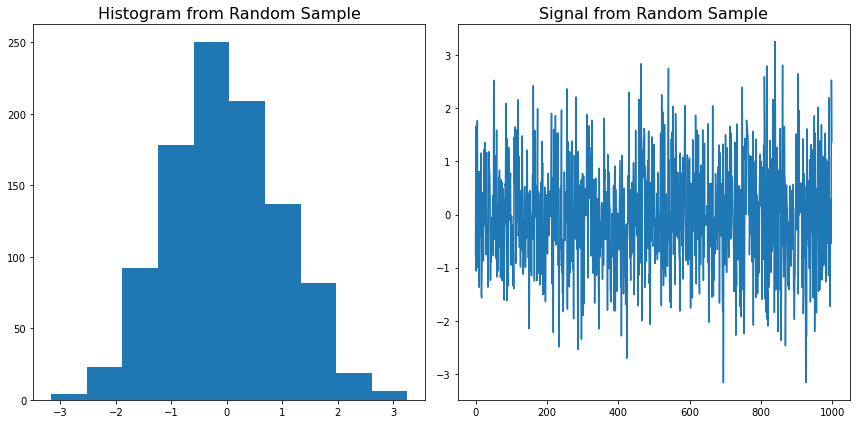

In [13]:
# plot random sample 
made.plot_random_sample(dist, n=1000) 

<a name="3-4"></a> 

## Test Signal Probabilities 

[Section Outline](#3) 

Now that our initial distribution is transformed to fit the train signal, we can compute the probabilities of the test signal observations. 

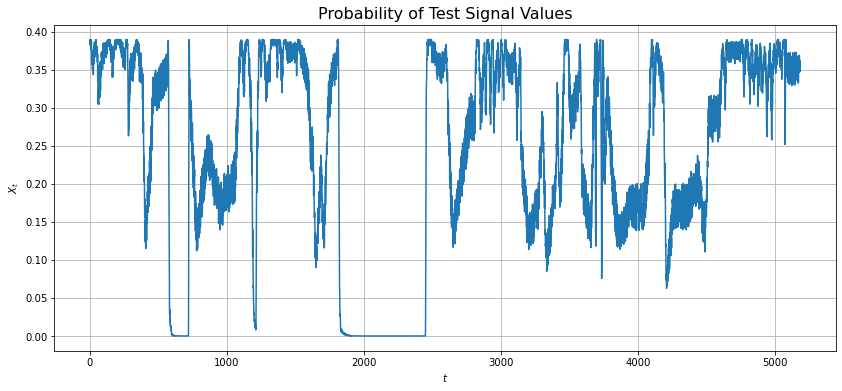

In [14]:
# test probabilities 
px = dist.prob(x_test).numpy() 

# plot test observation probabilities 
plot.signal_np(px, title='Probability of Test Signal Values') 

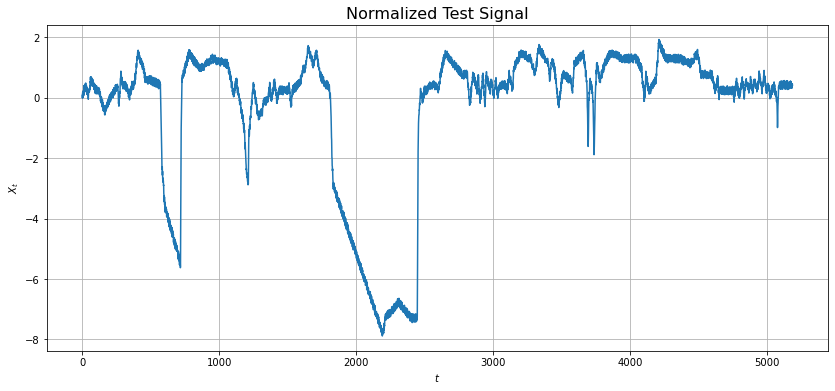

In [15]:
# plot test observations for comparison 
plot.signal_np(x_test, title='Normalized Test Signal') 

The plot of the probabilities suggests that there are a handful of observations that have a probability very close to 0. This means that there are likely anomalous portions of the signal considering that the signal comes from the same component of the same machine. 

---

<a name="3-5"></a> 

## Detect Anomalies 

[Section Outline](#3) 

Using the idea of a statistical hypothesis test, we will say that the observations do not belong to the systems distribution if their probabilities are less than 0.05. This will act as a probabilistic threshold to detect anomalies in the system. 

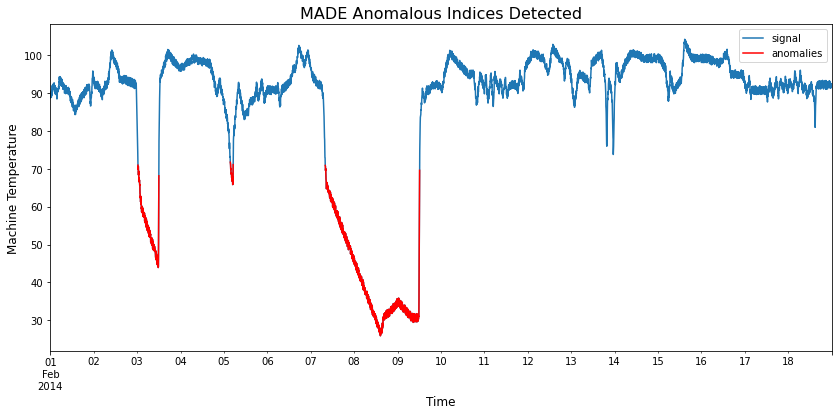

In [16]:
# let anomalous observations have p(x) < 0.05 
anoms = px < 0.05  

# plot anomalies 
plot.anomalies(signal_test, anoms, title='MADE Anomalous Indices Detected') 

Like the Hidden Markov Model, the Autoregressive Network captures both anomalies in the system with a false alarm in between. 

---

<a name="4"></a> 

# 4. Summary and Conclusion 

[Outline](#0) | [Section 2 Outline](#2) | [Section 3 Outline](#3) 

One notable difference is that the Hidden Markov model does not need to be fit to a stable part of the signal to detect anomalies, but it can be tricky since the number of states is user defined. One way around that is to use Bayesian model selection, but 3 states were selected in this case so the states and their latent means wouldn't vary as much with the number of observations in them. With more states selected, there would be a lot more transitions at smaller intervals which could make it difficult to select the anomalous state. 

MADE detected anomalies in a very different approach in comparison. It is a neural network that was fit to a stable portion of the signal that denotes how it should behave. Other types of autoencoders can also be implemented to anomaly detection as well but the approach is very different at the same time. Another application of autoencoders do not require density estimation, but they essentially learn a latent representation of smaller sequences and determine a reconstruction threshold to detect anomalies. 

---
